<a href="https://colab.research.google.com/github/annalimm/MultiTimeSeries_Transformer/blob/main/MultiTimeSer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.16-py3-none-any.whl size=28709 sha256=ab21f1387faa26674b47d8511ddce07c4f6a7c2679d31ced29cbf50668bb122b
  Stored in directory: /root/.cache/pip/wheels/fd/fe/c4/4b17989f30abf08d147a72cd1097ae0f6b1a1dd070f3abf726
Successfully built yahoofinancials


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from yahoofinancials import YahooFinancials
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn')

<ipython-input-4-8d9f1e8dd747>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Data

In [5]:
def get_historical_stock_data(ticker: str, start_date, end_date):
    try:
        raw_data = YahooFinancials(ticker)
        historical_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
        prices = historical_data.get(ticker, {}).get("prices", [])  # Necessary block of stocks data
        if not prices:
            return pd.DataFrame()
        df = pd.DataFrame(prices)
        df['date'] = pd.to_datetime(df['formatted_date'] + ' 14:30:00')  # investigate which time of the day is the best
        df = df[['date', 'open', 'high', 'low', 'adjclose', 'volume']]
        df['volume'].replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
        df.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
        #df.set_index('DateTime', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return pd.DataFrame()  # Return an empty DataFrame if no data is available


def fetch_tickers_data(tickers: list, start_date, end_date) -> pd.DataFrame:
    data_frames = []

    for ticker in tickers:
        ticker_data = get_historical_stock_data(ticker, start_date, end_date)
        if len(tickers) > 1 and not ticker_data.empty:
            ticker_data['Ticker'] = ticker  # Add a 'ticker' column to identify each ticker
        data_frames.append(ticker_data)

    if data_frames:
        concatenated_data = pd.concat(data_frames)
        return concatenated_data
    return pd.DataFrame()

We dont need more than one stock yet. We already have multivariate time series

But it's a good idea to study trends from few stocks later

In [6]:
# tickers = ['AAPL', 'META', 'MSFT']
tickers = ['IBM']
start_date = '1960-01-01'
end_date = '2022-02-25'

res_data = fetch_tickers_data(tickers, start_date, end_date)
print(res_data)

                 DateTime        Open        High         Low       Close  \
0     1962-01-02 14:30:00    7.374124    7.374124    7.291268    1.573411   
1     1962-01-03 14:30:00    7.291268    7.355003    7.291268    1.587165   
2     1962-01-04 14:30:00    7.355003    7.355003    7.278521    1.571347   
3     1962-01-05 14:30:00    7.272148    7.272148    7.125558    1.540403   
4     1962-01-08 14:30:00    7.131931    7.131931    6.947100    1.511518   
...                   ...         ...         ...         ...         ...   
15137 2022-02-17 14:30:00  128.050003  128.500000  124.849998  116.099701   
15138 2022-02-18 14:30:00  124.940002  125.440002  123.610001  115.523705   
15139 2022-02-22 14:30:00  124.199997  125.000000  122.680000  115.124229   
15140 2022-02-23 14:30:00  124.379997  124.699997  121.870003  113.405533   
15141 2022-02-24 14:30:00  120.000000  122.099998  118.809998  113.312637   

        Volume  
0       407940  
1       305955  
2       274575  
3      

In [7]:
# res_data.index

In [8]:
type(res_data)

pandas.core.frame.DataFrame

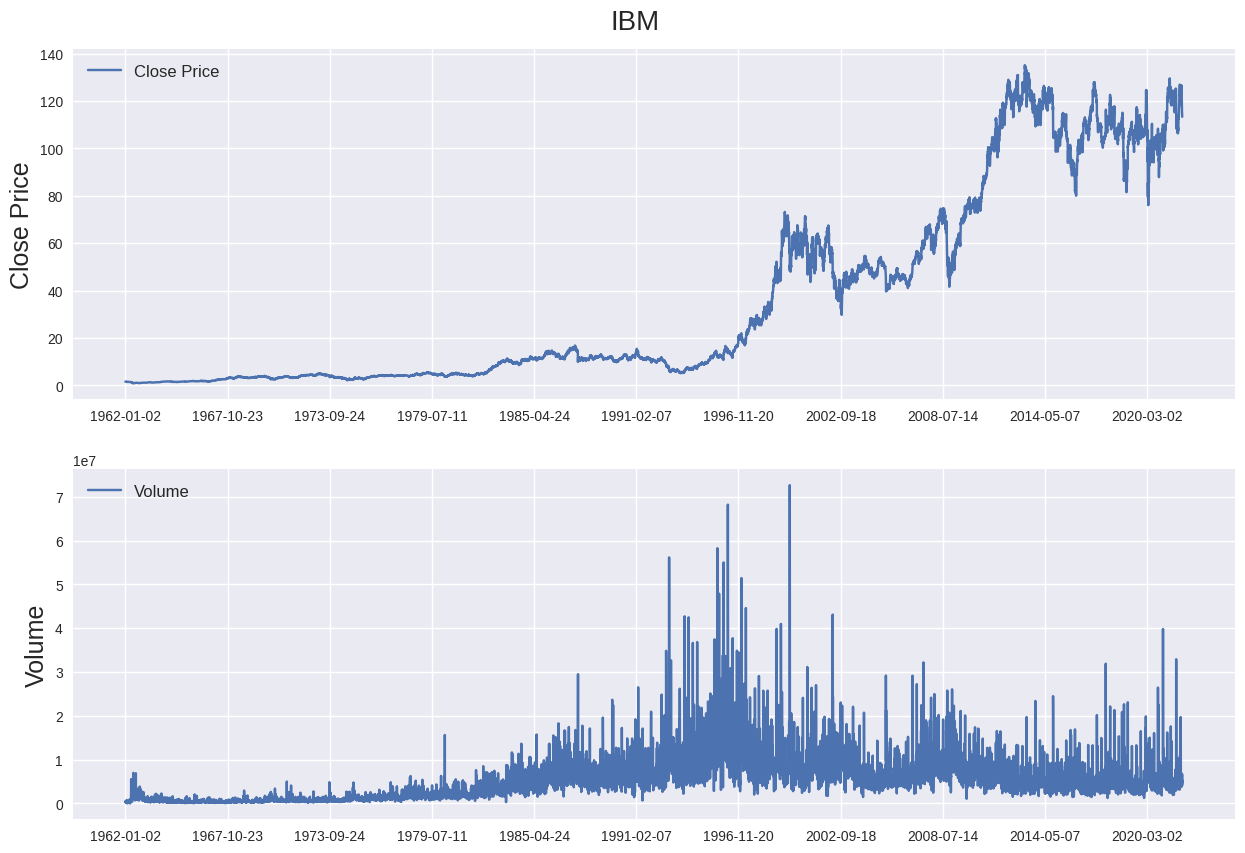

In [9]:
def stock_plot(stock_str, df):
  fig = plt.figure(figsize=(15,10))
  st = fig.suptitle(stock_str, fontsize=20)
  st.set_y(0.92)

  ax1 = fig.add_subplot(211)
  ax1.plot(df['Close'], label='Close Price')
  ax1.set_xticks(range(0, df.shape[0], 1464))
  ax1.set_xticklabels(df['DateTime'].dt.strftime('%Y-%m-%d').loc[::1464])
  ax1.set_ylabel('Close Price', fontsize=18)
  ax1.legend(loc="upper left", fontsize=12)

  ax2 = fig.add_subplot(212)
  ax2.plot(df['Volume'], label='Volume')
  ax2.set_xticks(range(0, df.shape[0], 1464))
  ax2.set_xticklabels(df['DateTime'].dt.strftime('%Y-%m-%d').loc[::1464])
  ax2.set_ylabel('Volume', fontsize=18)
  ax2.legend(loc="upper left", fontsize=12)


stock_plot("IBM", res_data)

# Data engineering

## Data converting

In [10]:
# price converts to daily stock returns and volume converts to daily volume changes
df = pd.DataFrame()
# the percentage change between the current element and the previous element
df['Open'] = res_data['Open'].pct_change()
df['High'] = res_data['High'].pct_change()
df['Low'] = res_data['Low'].pct_change()
df['Close'] = res_data['Close'].pct_change()
df['Volume'] = res_data['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

## min-max normalization

important not only in terms of understandability of results, but also for training itself

activations (the result of applying a weighted sum of the inputs, followed by an activation function (e.g., ReLU, sigmoid, or tanh)) can become very large or very small during forward and backward passes.  

Large activations can lead to gradients that explode, making it challenging to train the network. On the other hand, very small activations can result in vanishing gradients, which hinder learning.

In [11]:
# we normalise train data separately, so that it will not give us
# the information from the future and there will be no data leakage
min_return = min(df[: int(len(df)*0.8)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[: int(len(df)*0.8)][['Open', 'High', 'Low', 'Close']].max(axis=0))
min_volume = df[: int(len(df)*0.8)]['Volume'].min(axis=0)
max_volume = df[: int(len(df)*0.8)]['Volume'].max(axis=0)

# normilize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

# normilize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

## Train, test, validation data

In [12]:
# we maintain chronological order for time-series
train_samples = int(len(df) * 0.8)
val_samples = int(len(df) * 0.1)

df_train = df[:train_samples]
df_val = df[train_samples: train_samples + val_samples]
df_test = df[train_samples + val_samples:]

# remove date column (now we'll do just like that, but maybe later we can somehow use data better - time2Vec)
df_train = df_train.loc[:, df_train.columns != 'DateTime']
df_val = df_val.loc[:, df_val.columns != 'DateTime']
df_test = df_test.loc[:, df_test.columns != 'DateTime']

print(df_train.shape)
print(df_val.shape)

(12112, 5)
(1514, 5)


In [13]:
# convert pd colums inro arrays for Transformer
train_arr = df_train.values
val_arr = df_val.values
test_arr = df_test.values

print('Train data shape: {}'.format(train_arr.shape))
print('Test data shape: {}'.format(test_arr.shape))
print('Val data shape: {}'.format(val_arr.shape))

Train data shape: (12112, 5)
Test data shape: (1515, 5)
Val data shape: (1514, 5)


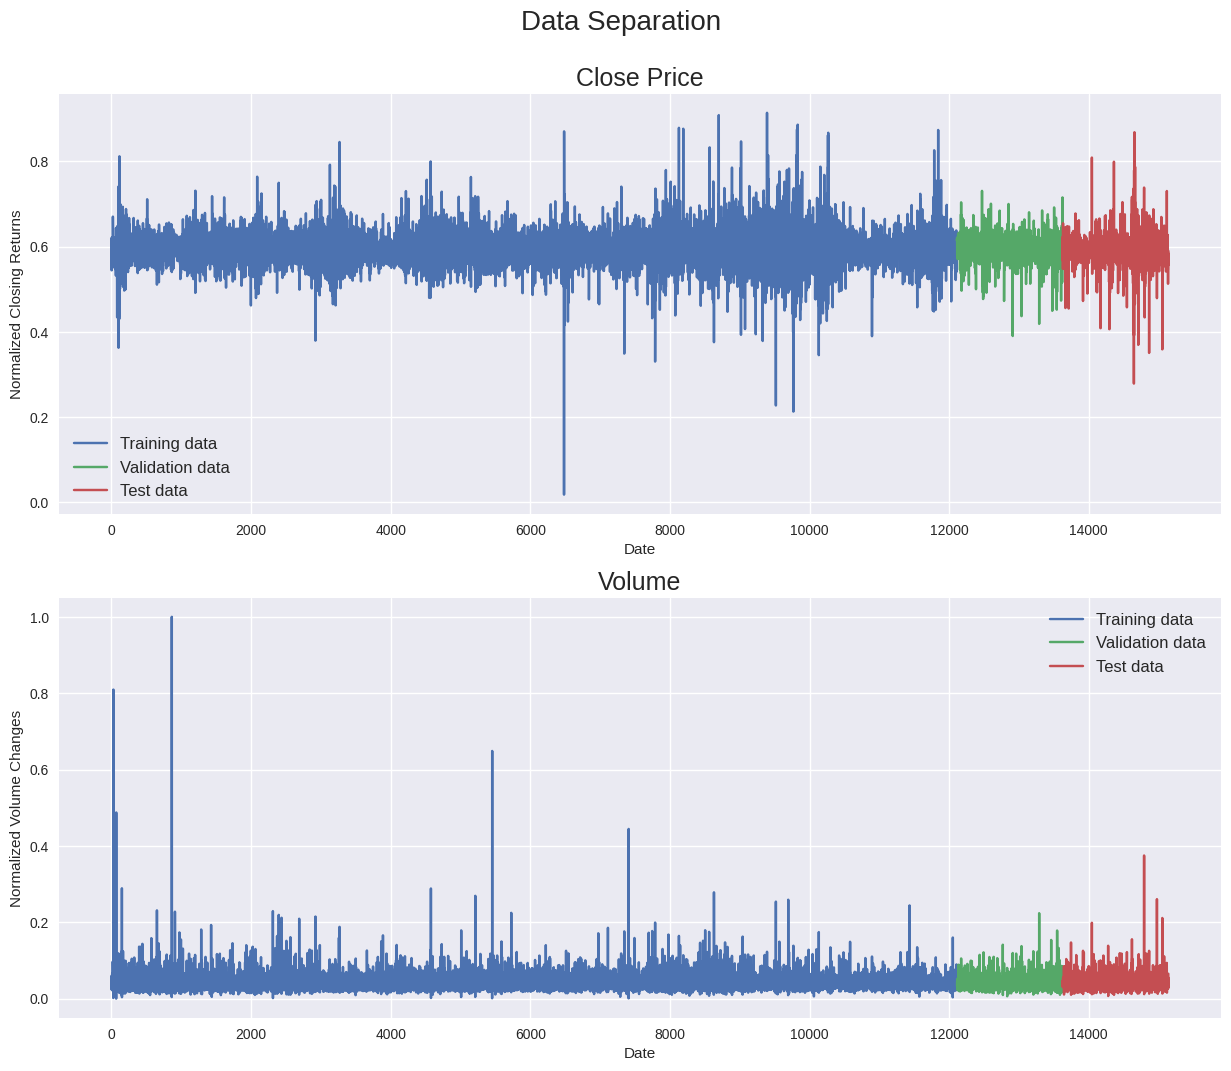

In [14]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_arr.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_arr.shape[0],
                   train_arr.shape[0]+val_arr.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_arr.shape[0]+val_arr.shape[0],
                   train_arr.shape[0]+val_arr.shape[0]+test_arr.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_arr.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_arr.shape[0],
                   train_arr.shape[0]+val_arr.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_arr.shape[0]+val_arr.shape[0],
                   train_arr.shape[0]+val_arr.shape[0]+test_arr.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## "rolling window" or "sliding window" approach for time-series (test if it's needed)

Here we create sequences of data points, which we then use as imput for training.

Sequence length parametr is important for Transformer.

"A longer sequence can capture longer-term dependencies, but it might also introduce more complexity and computation."

Plan:

- Begin with an initial sequence length and use it for model training.

- Monitor the model's performance on the validation set using this sequence length.

- Experiment with different sequence lengths and train separate models with varying sequence lengths.

In [15]:
seq_len = 128 # or in other word timesteps

In [16]:
# Train data
X_train, y_train = [], []

for i in range(seq_len, len(train_arr)):
    # we use all colums for training, split data by subsets with 128 rows and move by step = 1
    X_train.append(train_arr[i-seq_len:i])
    # we use only i-th value form Close column as a target
    # nevertheless, we can predict all 5 parameters
    y_train.append(train_arr[:, 3][i])

X_train, y_train = np.array(X_train), np.array(y_train)


#len of val_arr and test_arr is differ by 1
# Val data
X_val, y_val = [], []
for i in range(seq_len, len(val_arr)):
    X_val.append(val_arr[i-seq_len:i])
    y_val.append(val_arr[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_arr)):
    X_test.append(test_arr[i-seq_len:i])
    y_test.append(test_arr[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Train set shape: ", X_train.shape, y_train.shape)
print("Val set shape: ", X_val.shape, y_val.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

Train set shape:  (11984, 128, 5) (11984,)
Val set shape:  (1386, 128, 5) (1386,)
Test set shape:  (1387, 128, 5) (1387,)


## TimeEmbedding

ChatGPT: "Time embeddings can be a crucial component in a time-series Transformer model, especially when dealing with sequential data where the temporal order of the data points matters. Time embeddings help the model capture temporal patterns and dependencies in the data."

In [17]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    # 4 matrices: 2 by 2 for both non-periodical (linear) and the periodical (sin) features
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

## Model (tf realization)

model's imput [#batchs, #timesteps, features]

batchs -- how many stocks sequences we want to feed at once

With prepared tensorflow.layers prepared Model (Kaggle_Teans & FordATS notebooks) it didn't work. Probably, cause it's not adapted for multiple time-series

In [18]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [19]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

### Hyperparametrs

In [20]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

### Without timeEmb.

In [23]:
def create_model():
    '''Initialize time and transformer layers'''
    # time_embedding = Time2Vector(seq_len)
    #why 3 of them?
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, 5))
    # x = time_embedding(in_seq)
    # x = Concatenate(axis=-1)([in_seq, x])
    # x = attn_layer1((x, x, x))
    x = attn_layer1((in_seq, in_seq, in_seq))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x) # regression head

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model


model = create_model()
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=4,
          callbacks=callbacks,
          validation_data=(X_val, y_val))

model.evaluate(X_test, y_test, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 5)]             0         []                            
                                                                                                  
 transformer_encoder_3 (Tra  (None, 128, 5)               73502     ['input_2[0][0]',             
 nsformerEncoder)                                                    'input_2[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 transformer_encoder_4 (Tra  (None, 128, 5)               73502     ['transformer_encoder_3[0][0]'
 nsformerEncoder)                                                   , 'transformer_encoder_3

[0.0018399643013253808, 0.02931361272931099, 5.205382823944092]

In [1]:
#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)


'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer without TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

NameError: ignored

Code with timeEmb (without data normalization) gives sooner less loss than without. But still loss is big.

In [ ]:
# with time-emb
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    #why 3 of them?
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, 5))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x) # regression head

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model


model = create_model()
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=2,
          callbacks=callbacks,
          validation_data=(X_val, y_val))

model.evaluate(X_test, y_test, verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 5)]             0         []                            
                                                                                                  
 time2_vector (Time2Vector)  (None, 128, 2)               512       ['input_6[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 128, 7)               0         ['input_6[0][0]',             
                                                                     'time2_vector[0][0]']        
                                                                                                  
 transformer_encoder_15 (Tr  (None, 128, 7)               99114     ['concatenate[0][0]',   

KeyboardInterrupt: ignored